In [ ]:
!pip install albumentations -U
!pip install opencv-python-headless==4.1.2.30

ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.1.2.30 (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72, 4.8.0.74, 4.8.0.76)
ERROR: No matching distribution found for opencv-python-headless==4.1.2.30


In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset

from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from math import log10
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
device = torch.device('cuda')

In [ ]:
class DnCNN(nn.Module):
  def __init__(self, n_layers=18):
    super(DnCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False)
    self.relu1 = nn.ReLU(inplace=True)

    hidden_layers = []
    for _ in range(n_layers):
      hidden_layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
      hidden_layers.append(nn.BatchNorm2d(64))
      hidden_layers.append(nn.ReLU(inplace=True))
    self.hidden = nn.Sequential(*hidden_layers)
    self.out = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1, bias=False)

  def forward(self, x):
    out = self.relu1(self.conv1(x))
    out = self.hidden(out)
    out = self.out(out)
    return out

In [ ]:
model = DnCNN(n_layers=17).to(device)
model.eval()
output = model(torch.ones(1, 3, 100, 100).to(device))

In [ ]:
output.shape

torch.Size([1, 3, 100, 100])

In [3]:
class UniversalDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, gaussian_noise_level=(0, 55),
                 transform=None):
      self.data = dataset
      self.transforms = transform
      self.gaussian_noise_level = gaussian_noise_level

    def __len__(self):
        return self.data.__len__()

    def __getitem__(self, idx):
      clean_image, label = self.data.__getitem__(idx)

      noisy_image = clean_image.copy()
      gaussian_noise = np.zeros((100, 100, 3), dtype=np.float32)

      sigma = random.randint(self.gaussian_noise_level[0], self.gaussian_noise_level[1])
      gaussian_noise += np.random.normal(0.0, sigma, (100, 100, 3)).astype(np.float32)

      image = np.array(clean_image)
      image = cv2.resize(image, (100, 100))
      noisy_image = cv2.resize(np.array(noisy_image), (100, 100)).astype(np.float32)

      if self.transforms:
        img = self.transforms(image=image)['image']

      noisy_image += gaussian_noise
      return img, torch.Tensor(image), torch.Tensor(gaussian_noise), torch.Tensor(noisy_image)

In [4]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [5]:
train_transforms = A.Compose(
[
      A.OneOf([
               A.GaussNoise(var_limit=(10, 100), p=1),
               A.ISONoise(intensity=(0.3, 0.9), p=1),
               A.MultiplicativeNoise(p=1)
               ]),
      ToTensorV2()
])
dataset = UniversalDataset(torchvision.datasets.STL10('.../train', download=True),
                           transform=train_transforms)

100%|██████████| 2640397119/2640397119 [02:20<00:00, 18848720.25it/s]


Extracting .../train/stl10_binary.tar.gz to .../train


In [ ]:
img1, img2, _, _ = dataset.__getitem__(0)

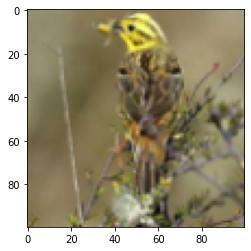

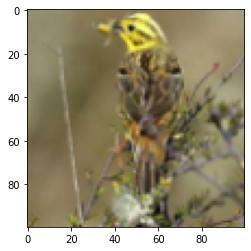

In [ ]:
plt.imshow(img1.permute(1, 2, 0).numpy())
plt.show()

plt.imshow(img2.numpy().astype(np.uint8))
plt.show()

In [ ]:
dataset = train_val_dataset(dataset)

train_dataset = dataset['val']

batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)

criterion = nn.MSELoss()

lr = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=lr)
model = model.to(device)

NameError: ignored

In [ ]:
epochs = 5
for epoch in range(1, epochs+1):
  epoch_loss = 0
  model.train()
  for iteration, data in enumerate(train_dataloader):

      input, target, _, _ = data
      input, target = input.to(device)/255, target.to(device)/255

      output = model(input)

      loss = criterion(output, target.permute(0, 3, 1, 2))
      epoch_loss += loss.item()

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()


      print("===> Epoch[{}]({}/{}): "
            "Loss: {:.4f}".format(epoch, iteration,
                                  len(train_dataloader),
                                  loss.item()))
  print("===> Epoch {} Complete: "
        "Avg. Loss: {:.4f}".format(epoch,
                                    epoch_loss / len(train_dataloader)))


  avg_psnr = 0
  model.eval()
  with torch.no_grad():
      for data in train_dataloader:
        input, target, _, _ = data
        input, target = input.to(device)/255, target.to(device)/255
        output = model(input)
        mse = criterion(output, target.permute(0, 3, 1, 2))
        psnr = 10 * log10(1 / mse.item())
        avg_psnr += psnr
  print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(train_dataloader)))

===> Epoch[1](0/40): Loss: 0.0112
===> Epoch[1](1/40): Loss: 0.0114
===> Epoch[1](2/40): Loss: 0.0113
===> Epoch[1](3/40): Loss: 0.0108
===> Epoch[1](4/40): Loss: 0.0116
===> Epoch[1](5/40): Loss: 0.0096
===> Epoch[1](6/40): Loss: 0.0113
===> Epoch[1](7/40): Loss: 0.0086
===> Epoch[1](8/40): Loss: 0.0119
===> Epoch[1](9/40): Loss: 0.0098
===> Epoch[1](10/40): Loss: 0.0110
===> Epoch[1](11/40): Loss: 0.0098
===> Epoch[1](12/40): Loss: 0.0111
===> Epoch[1](13/40): Loss: 0.0105
===> Epoch[1](14/40): Loss: 0.0108
===> Epoch[1](15/40): Loss: 0.0090
===> Epoch[1](16/40): Loss: 0.0109
===> Epoch[1](17/40): Loss: 0.0113
===> Epoch[1](18/40): Loss: 0.0099
===> Epoch[1](19/40): Loss: 0.0112
===> Epoch[1](20/40): Loss: 0.0095
===> Epoch[1](21/40): Loss: 0.0102
===> Epoch[1](22/40): Loss: 0.0091
===> Epoch[1](23/40): Loss: 0.0093
===> Epoch[1](24/40): Loss: 0.0092
===> Epoch[1](25/40): Loss: 0.0095
===> Epoch[1](26/40): Loss: 0.0103
===> Epoch[1](27/40): Loss: 0.0085
===> Epoch[1](28/40): Loss: 0.

В коде автора присутствует ошибка. Он в качестве входа берет картинку, а в качастве таргета тензор этой же самой картинки, а надо на вход подавать зашумленную картинку.

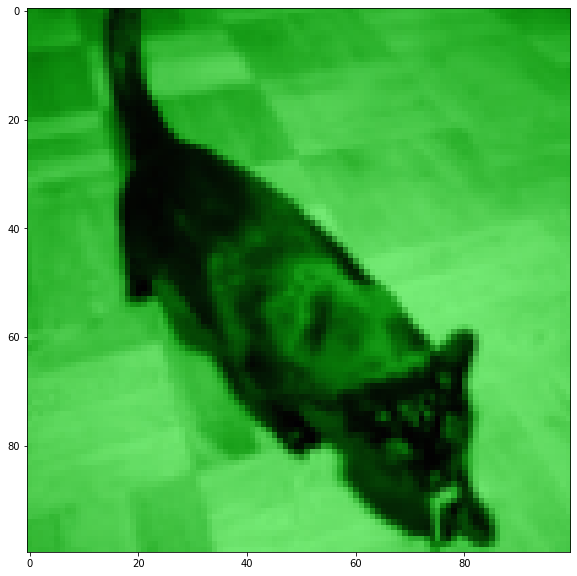

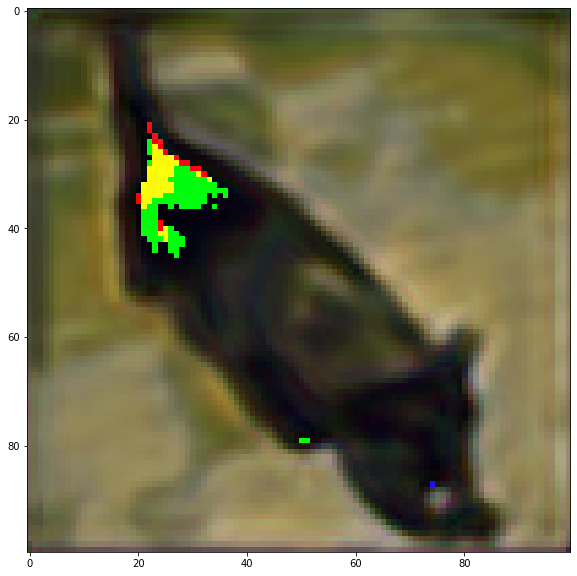

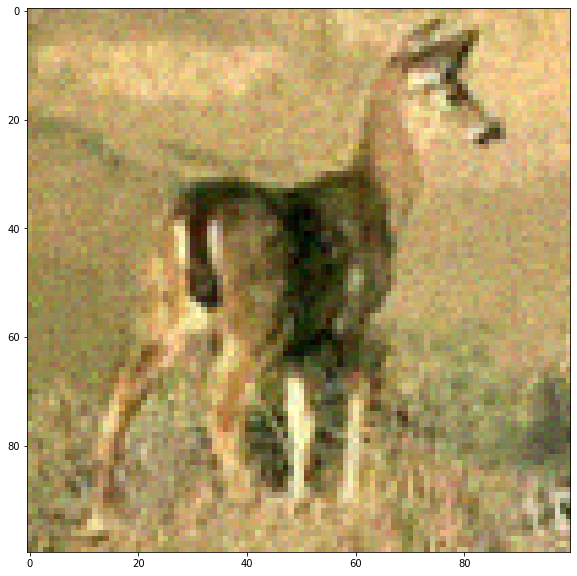

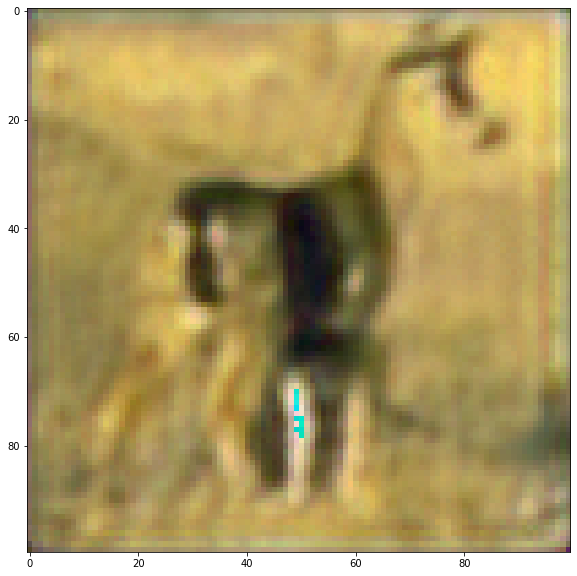

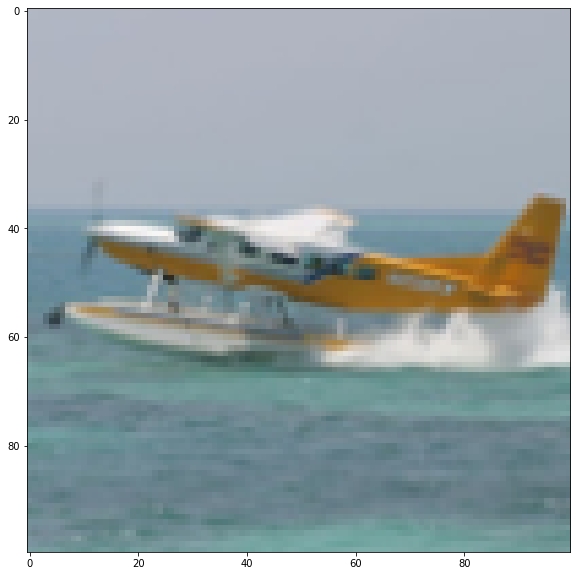

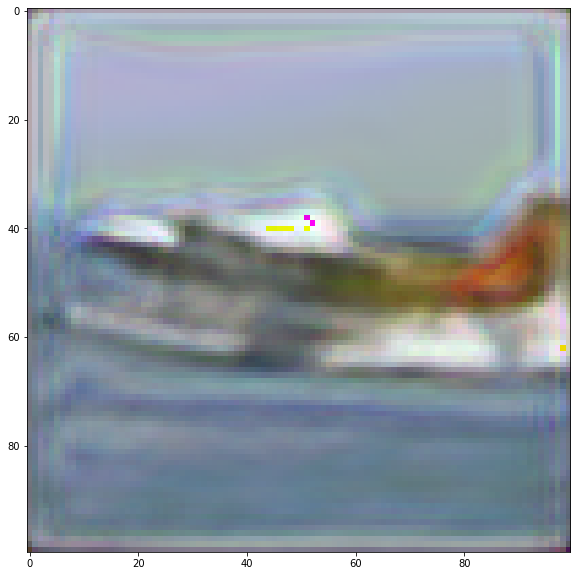

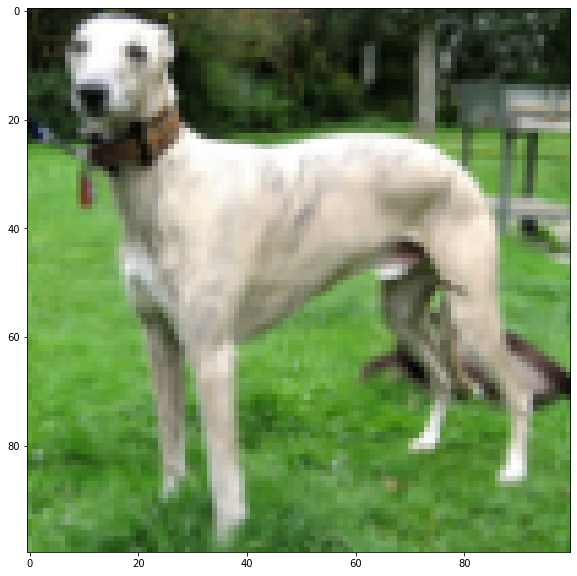

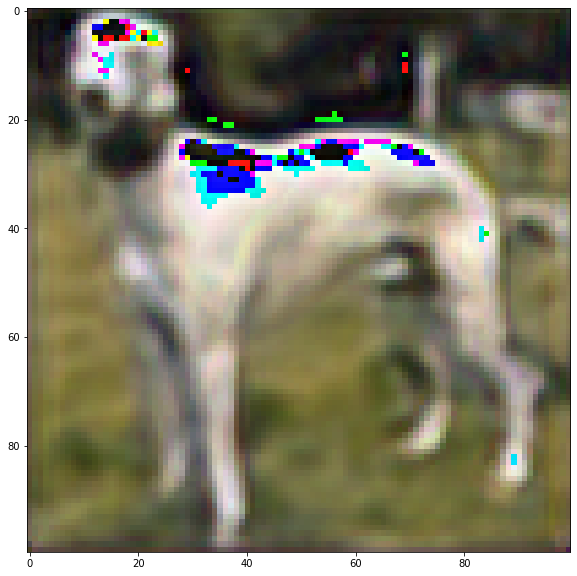

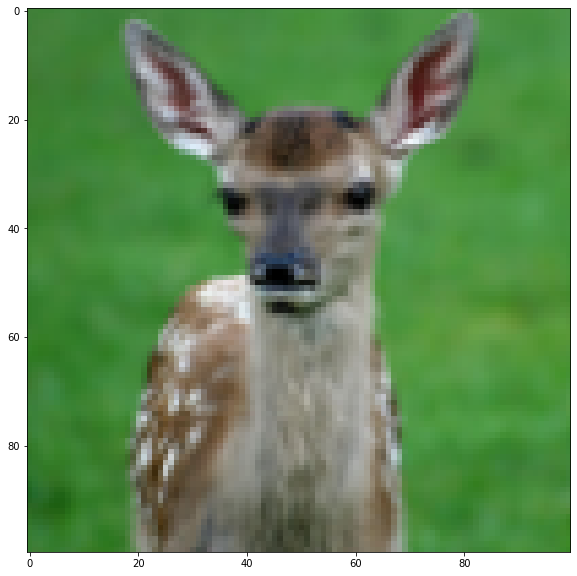

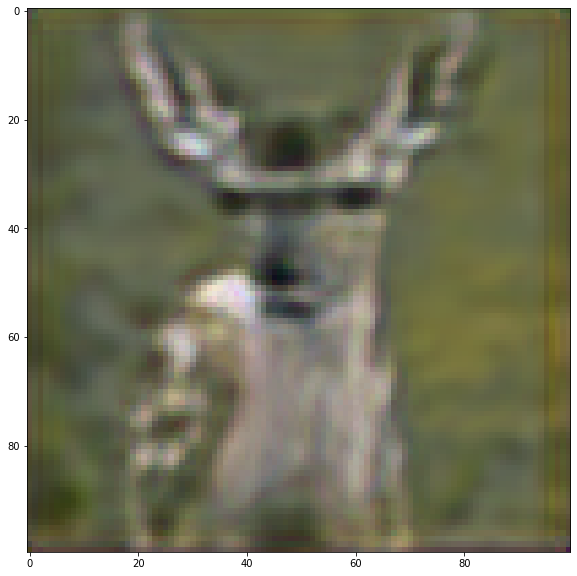

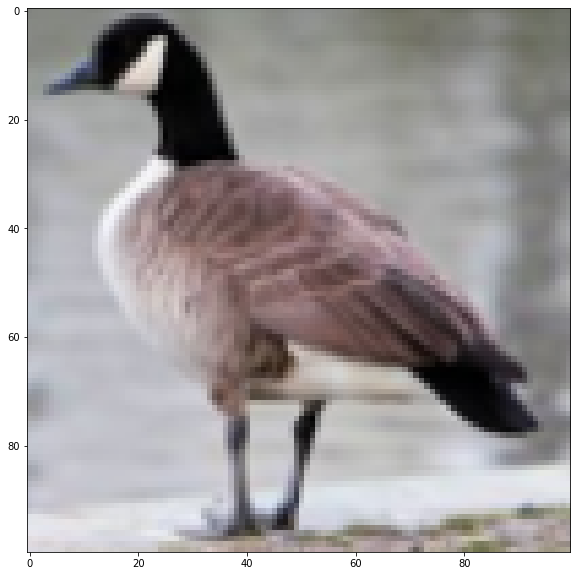

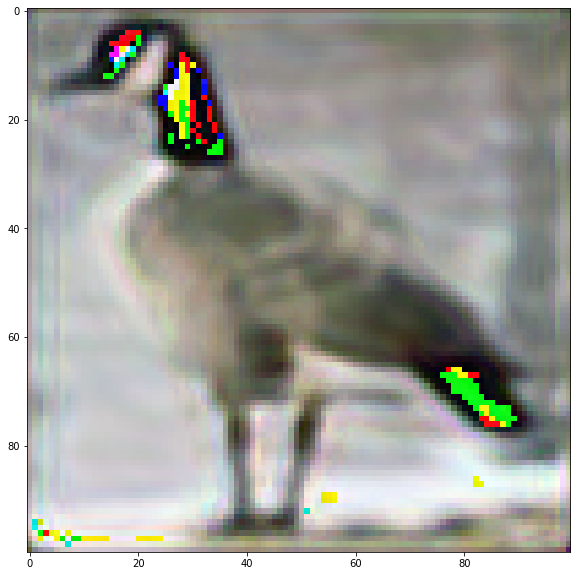

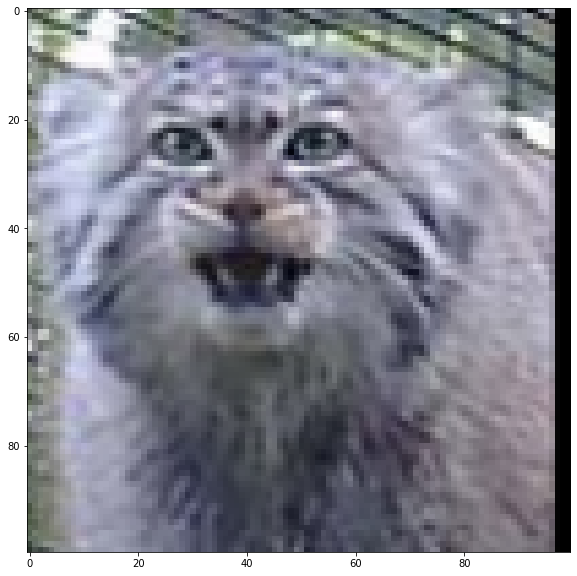

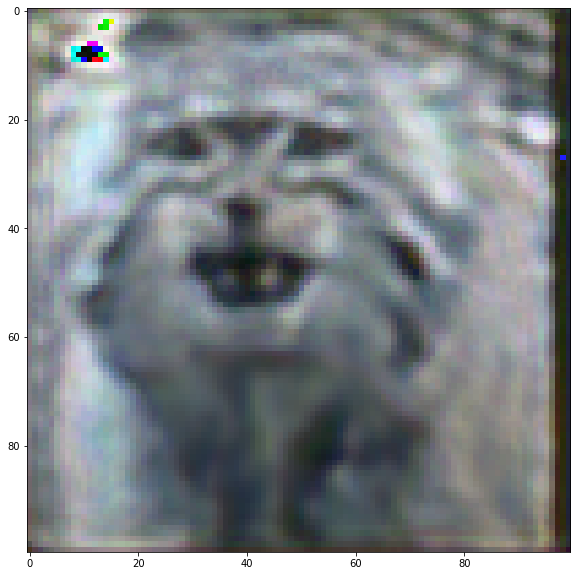

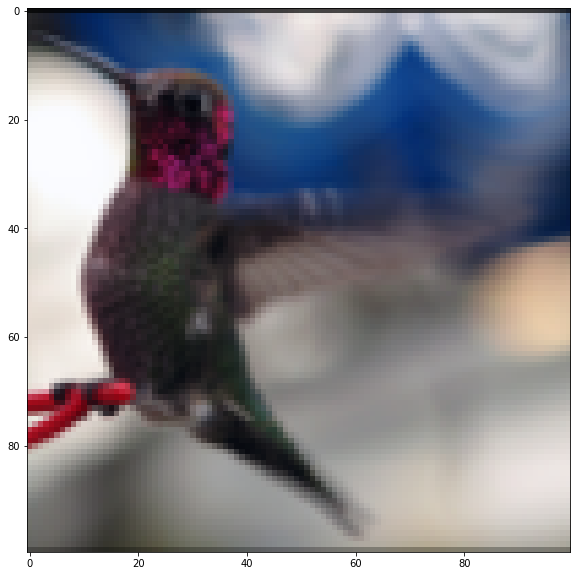

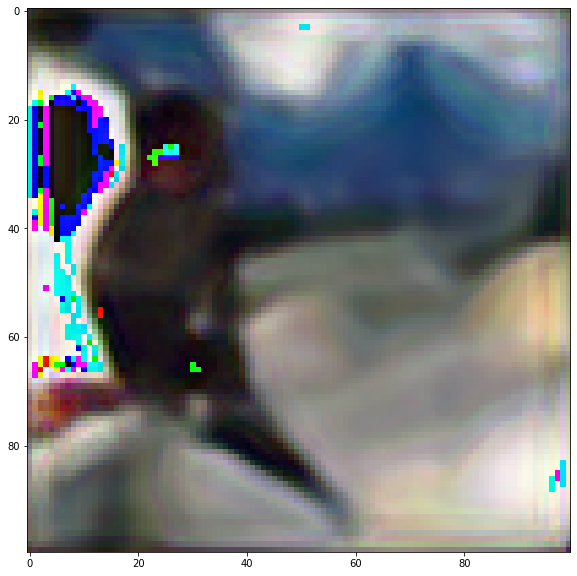

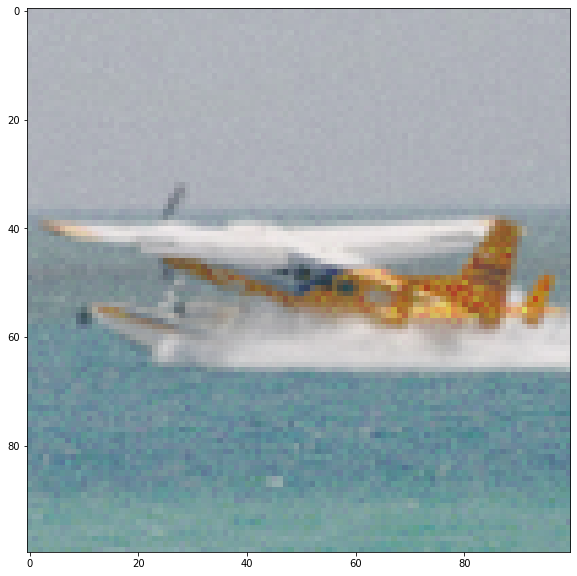

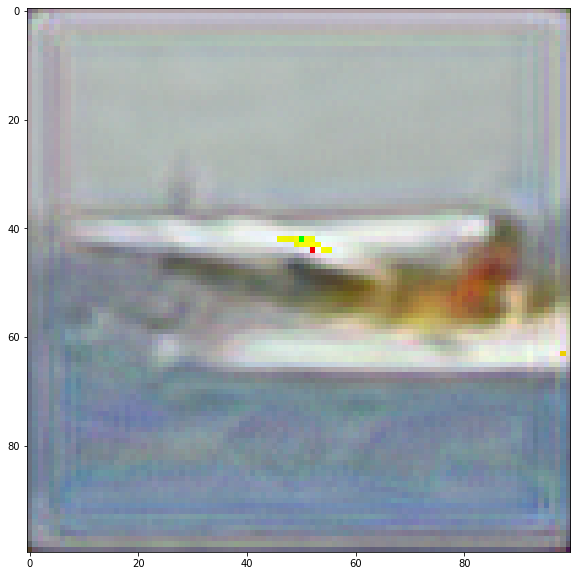

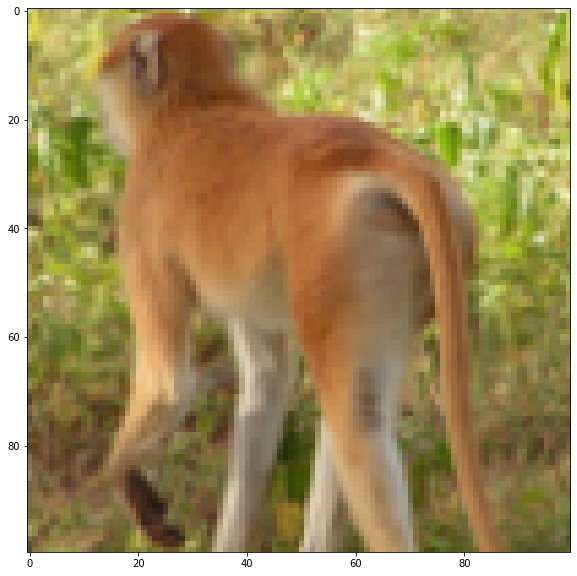

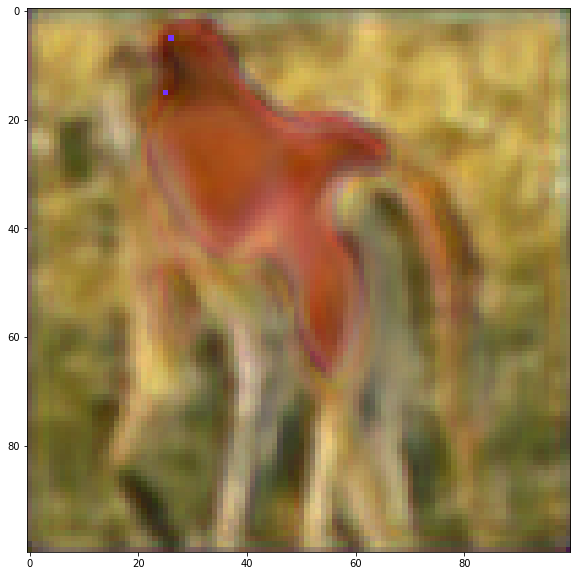

In [ ]:
k = 0
with torch.no_grad():
    for data in train_dataloader:
      input, target, _, _ = data
      input, target = input.to(device)/255, target.to(device)/255
      output = model(input)
      output = (output[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
      input = (input[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

      plt.figure(figsize=(10, 10))
      plt.imshow(input)
      plt.show()

      plt.figure(figsize=(10, 10))
      plt.imshow(output)
      plt.show()
      k+=1
      if k == 10:
        break

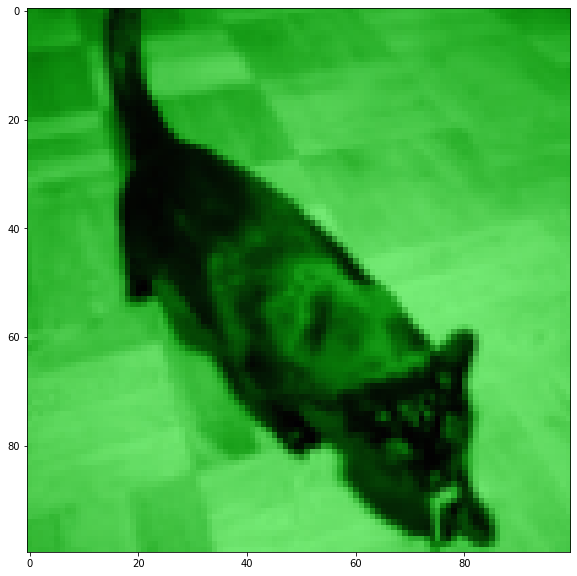

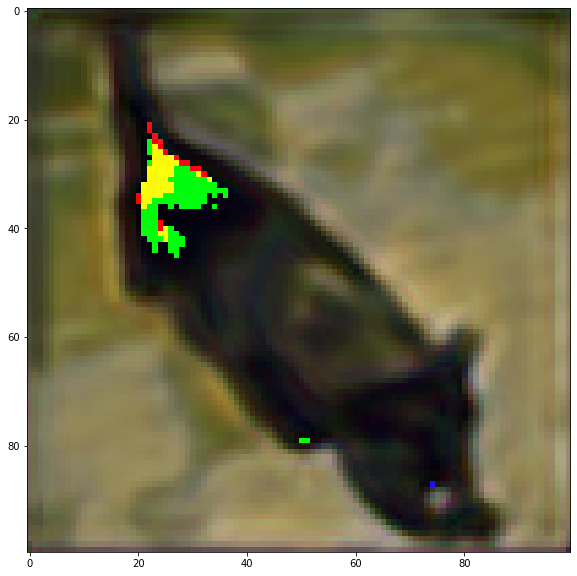

In [6]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(

         nn.ConvTranspose2d(in_channels=3, out_channels=1024, kernel_size=3, padding=1, bias=False),
         nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1, bias=False),
         nn.BatchNorm2d(512),
         nn.ReLU(inplace=True),
         nn.Dropout(),
         nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, bias=False),
         nn.BatchNorm2d(256),
         nn.ReLU(inplace=True),
         nn.Dropout(),
         nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, bias=False),
         nn.BatchNorm2d(128),
         nn.ReLU(inplace=True),
         nn.Dropout(),
         nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, bias=False),
         nn.BatchNorm2d(64),
         nn.ReLU(inplace=True)

    )
    self.decoder = nn.Sequential(

         nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False),
         nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False),
         nn.ConvTranspose2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=False),
         nn.ConvTranspose2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, bias=False),
         nn.Conv2d(in_channels=1024, out_channels=3, kernel_size=3, padding=1, bias=False)

    )

  def forward(self, x):
    x = self.encoder(x)
    out = self.decoder(x)
    return out

In [7]:
model = AutoEncoder().to(device)
model.eval()
output = model(torch.ones(1, 3, 100, 100).to(device))

In [8]:
output.shape

torch.Size([1, 3, 100, 100])

In [9]:
dataset_load = UniversalDataset(torchvision.datasets.STL10('.../train', download=True),
                           transform=train_transforms)

Files already downloaded and verified


Обучим наш автоэнкодер на тренировочной выборке. Будем брать в качестве входа тензор картинки с шумом, а в качестве таргете тензор исходного изображения.

In [10]:
dataset = train_val_dataset(dataset_load)

train_dataset = dataset['train']

batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)

criterion = nn.MSELoss()

lr = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=lr)
model = model.to(device)

In [11]:
epochs = 5
for epoch in range(1, epochs+1):
  epoch_loss = 0
  model.train()
  for iteration, data in enumerate(train_dataloader):

      _, target, _, input = data
      input, target = input.to(device)/255, target.to(device)/255

      output = model(input.permute(0, 3, 1, 2))

      loss = criterion(output, target.permute(0, 3, 1, 2))
      epoch_loss += loss.item()

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()


      print("===> Epoch[{}]({}/{}): "
            "Loss: {:.4f}".format(epoch, iteration,
                                  len(train_dataloader),
                                  loss.item()))
  print("===> Epoch {} Complete: "
        "Avg. Loss: {:.4f}".format(epoch,
                                    epoch_loss / len(train_dataloader)))


  avg_psnr = 0
  model.eval()
  with torch.no_grad():
      for data in train_dataloader:
        _, target, _, input = data
        input, target = input.to(device)/255, target.to(device)/255
        output = model(input.permute(0, 3, 1, 2))
        mse = criterion(output, target.permute(0, 3, 1, 2))
        psnr = 10 * log10(1 / mse.item())
        avg_psnr += psnr
  print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(train_dataloader)))

===> Epoch[1](0/118): Loss: 0.2469
===> Epoch[1](1/118): Loss: 0.1702
===> Epoch[1](2/118): Loss: 0.0462
===> Epoch[1](3/118): Loss: 0.1573
===> Epoch[1](4/118): Loss: 0.0249
===> Epoch[1](5/118): Loss: 0.0500
===> Epoch[1](6/118): Loss: 0.0812
===> Epoch[1](7/118): Loss: 0.0803
===> Epoch[1](8/118): Loss: 0.0407
===> Epoch[1](9/118): Loss: 0.0238
===> Epoch[1](10/118): Loss: 0.0227
===> Epoch[1](11/118): Loss: 0.0302
===> Epoch[1](12/118): Loss: 0.0373
===> Epoch[1](13/118): Loss: 0.0212
===> Epoch[1](14/118): Loss: 0.0146
===> Epoch[1](15/118): Loss: 0.0233
===> Epoch[1](16/118): Loss: 0.0254
===> Epoch[1](17/118): Loss: 0.0357
===> Epoch[1](18/118): Loss: 0.0188
===> Epoch[1](19/118): Loss: 0.0114
===> Epoch[1](20/118): Loss: 0.0144
===> Epoch[1](21/118): Loss: 0.0173
===> Epoch[1](22/118): Loss: 0.0199
===> Epoch[1](23/118): Loss: 0.0119
===> Epoch[1](24/118): Loss: 0.0130
===> Epoch[1](25/118): Loss: 0.0167
===> Epoch[1](26/118): Loss: 0.0165
===> Epoch[1](27/118): Loss: 0.0130
==

In [12]:
val_dataset = dataset['val']

batch_size = 32

val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size)

In [14]:
avg_psnr = 0
model.eval()
with torch.no_grad():
  for data in val_dataloader:
    _, target, _, input = data
    input, target = input.to(device)/255, target.to(device)/255
    output = model(input.permute(0, 3, 1, 2))
    mse = criterion(output, target.permute(0, 3, 1, 2))
    psnr = 10 * log10(1 / mse.item())
    avg_psnr += psnr
print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(val_dataloader)))

===> Avg. PSNR: 19.8516 dB


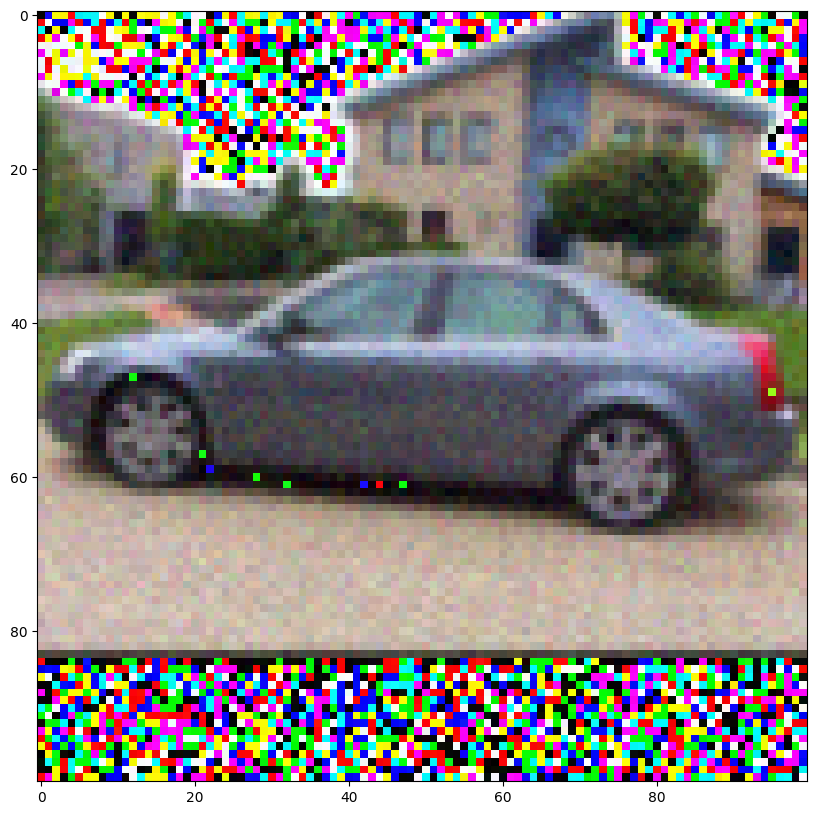

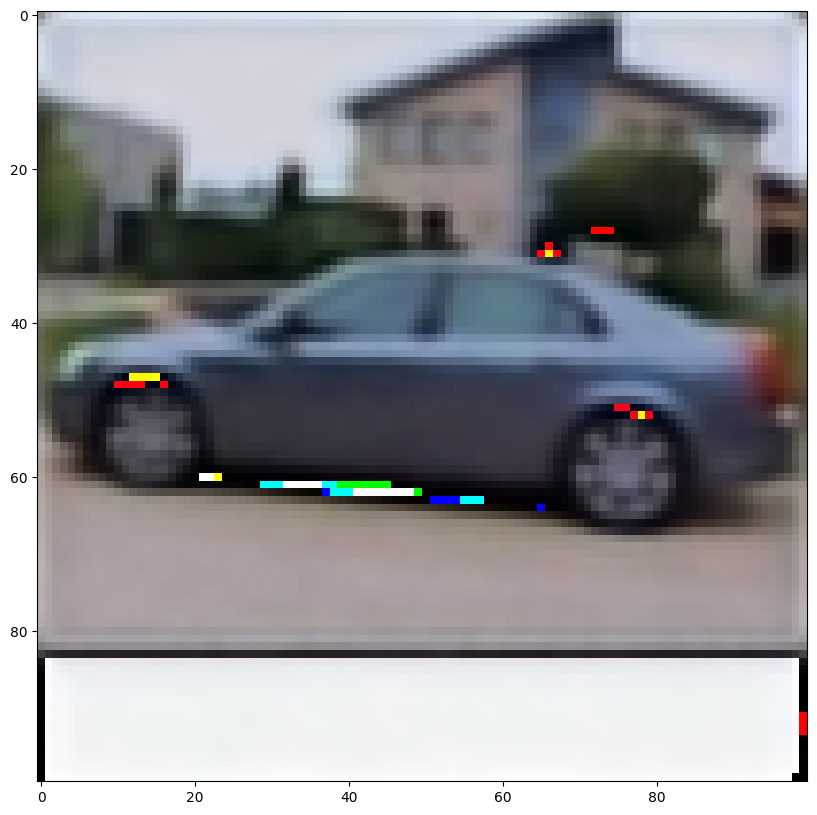

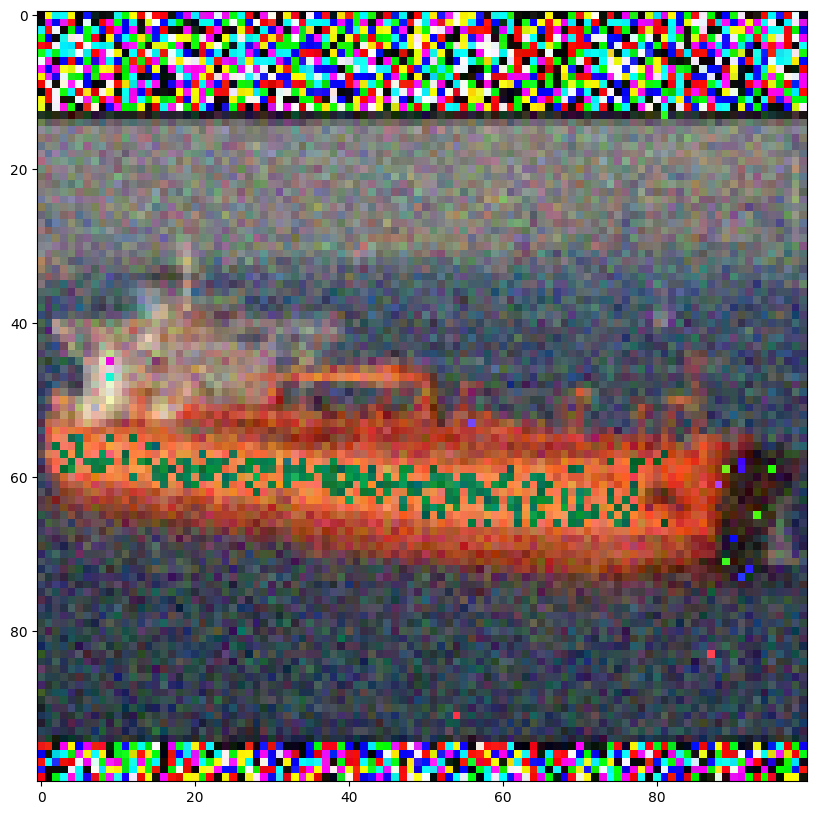

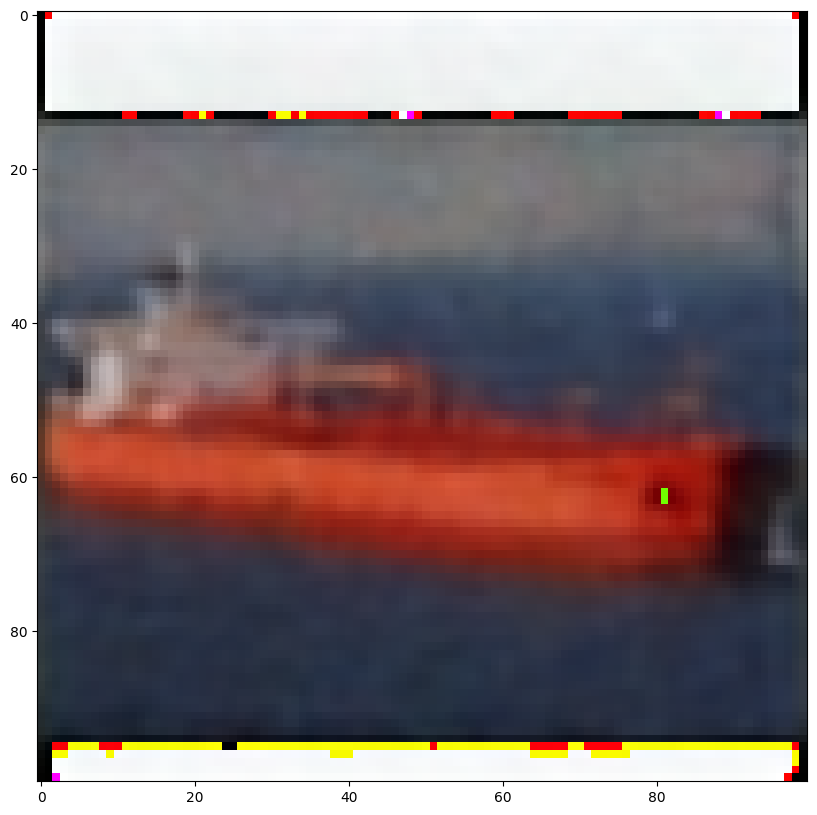

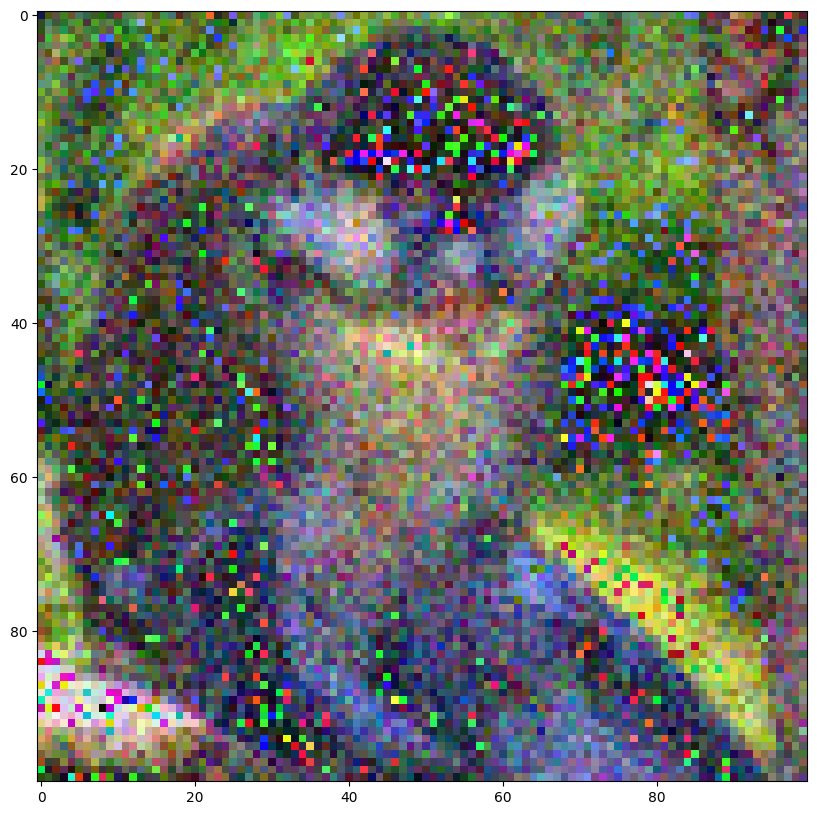

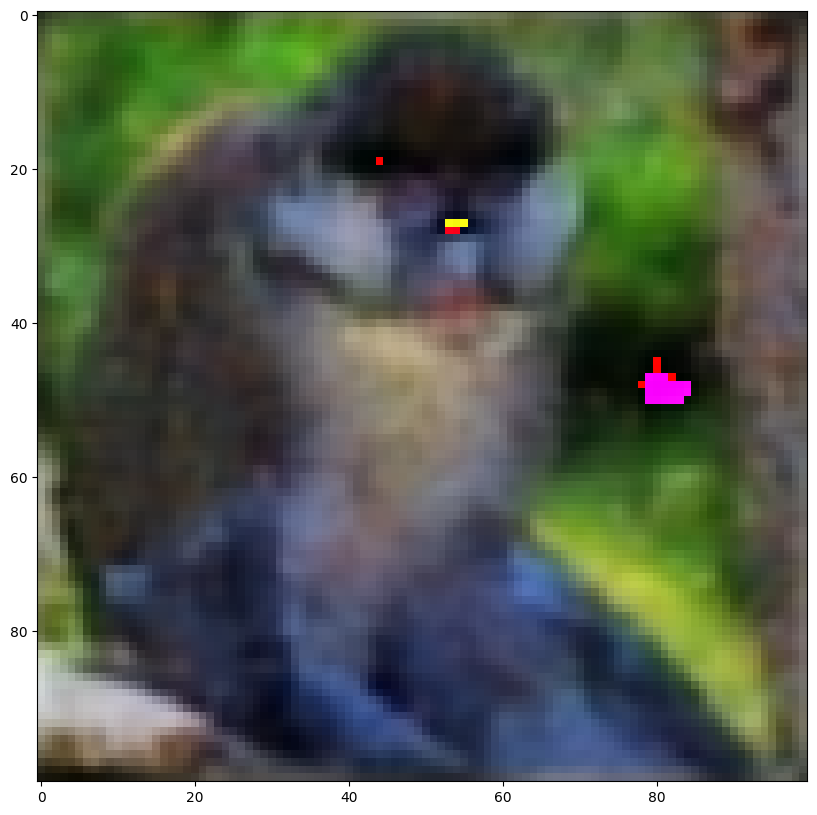

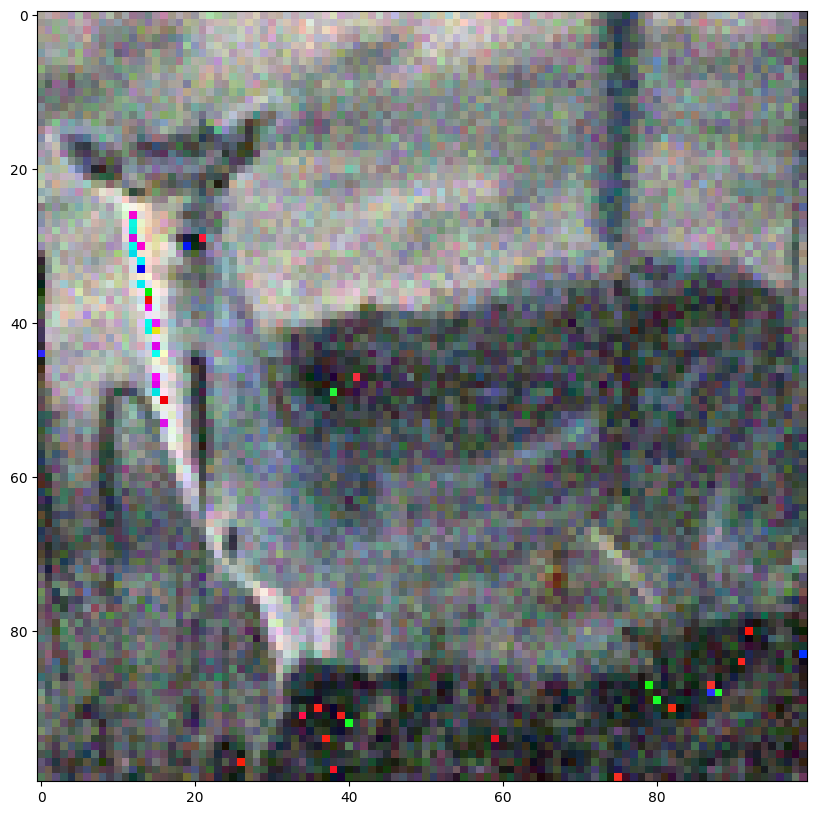

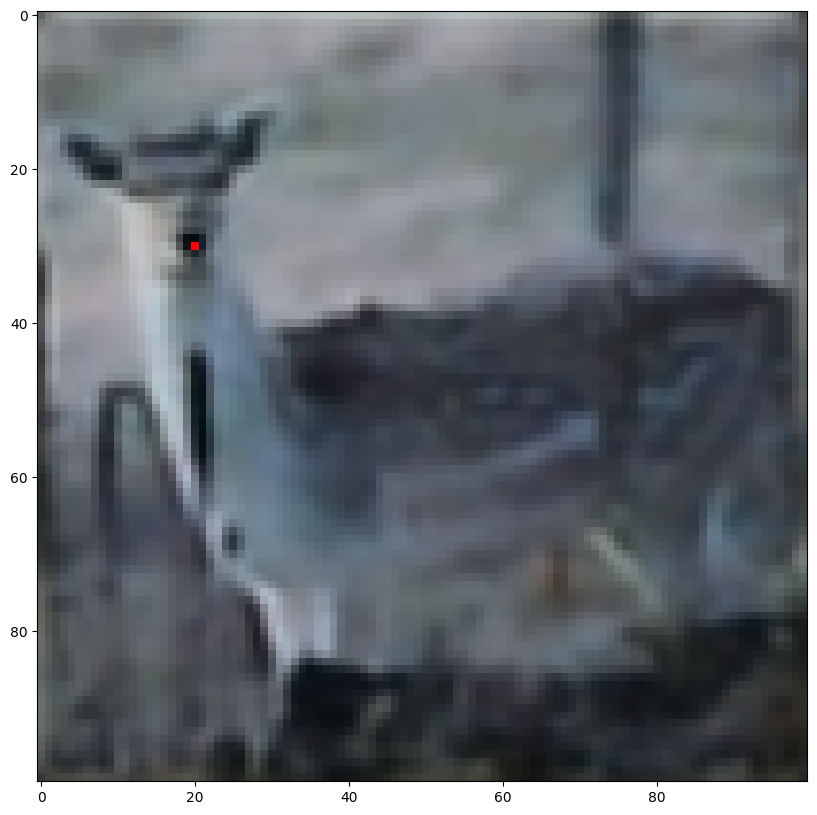

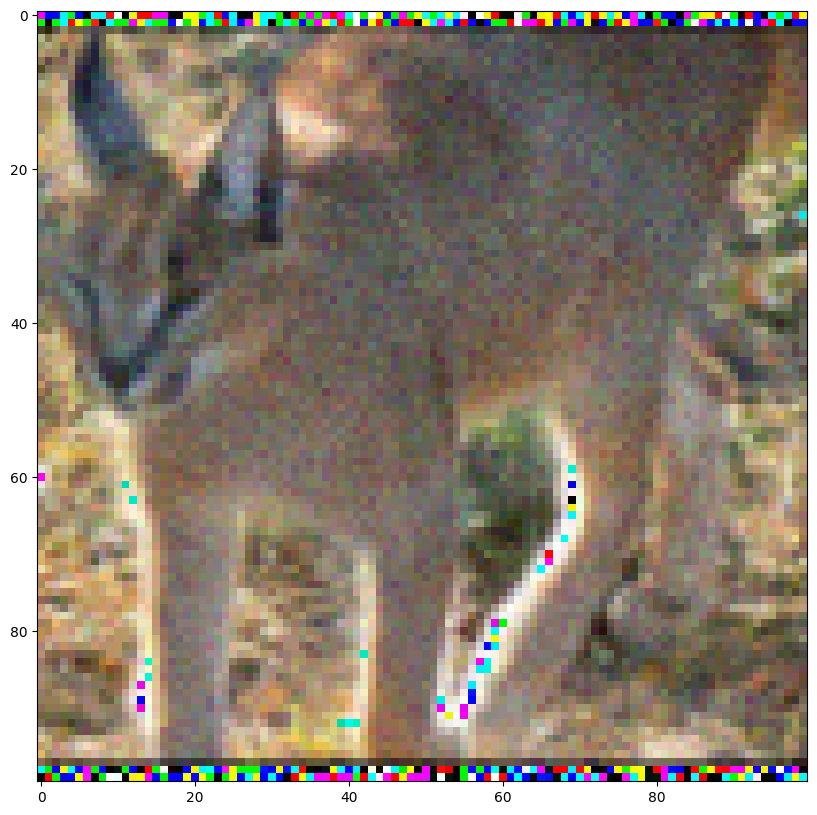

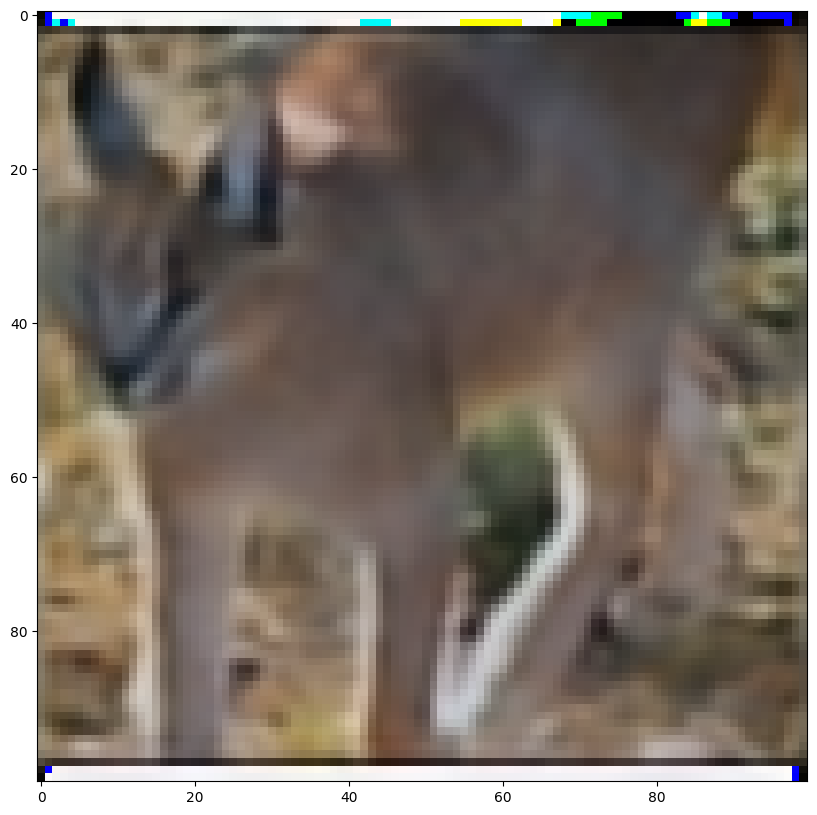

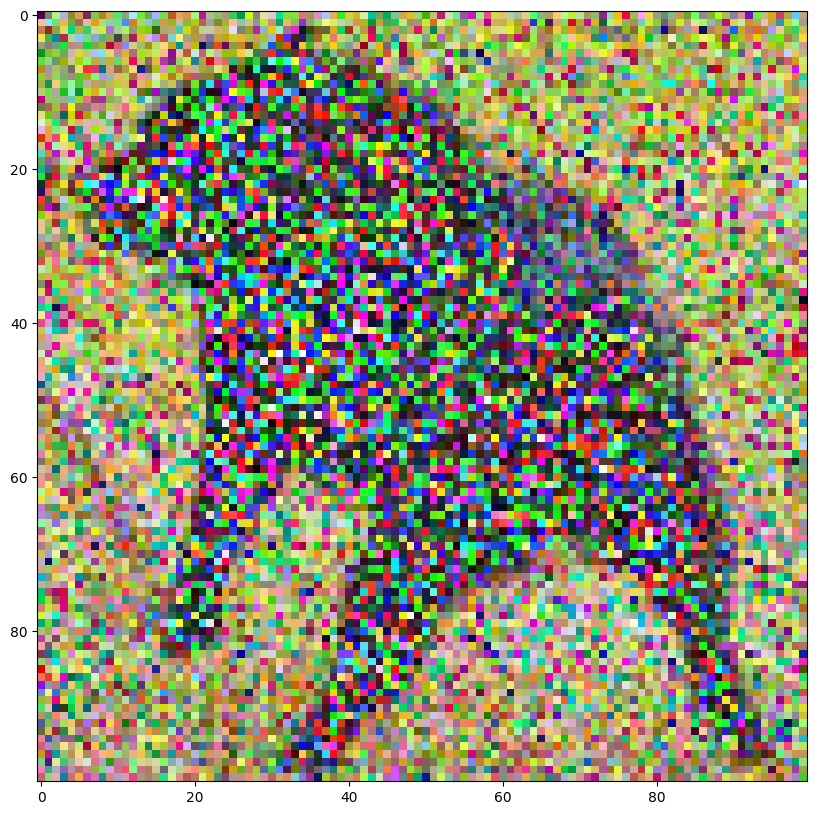

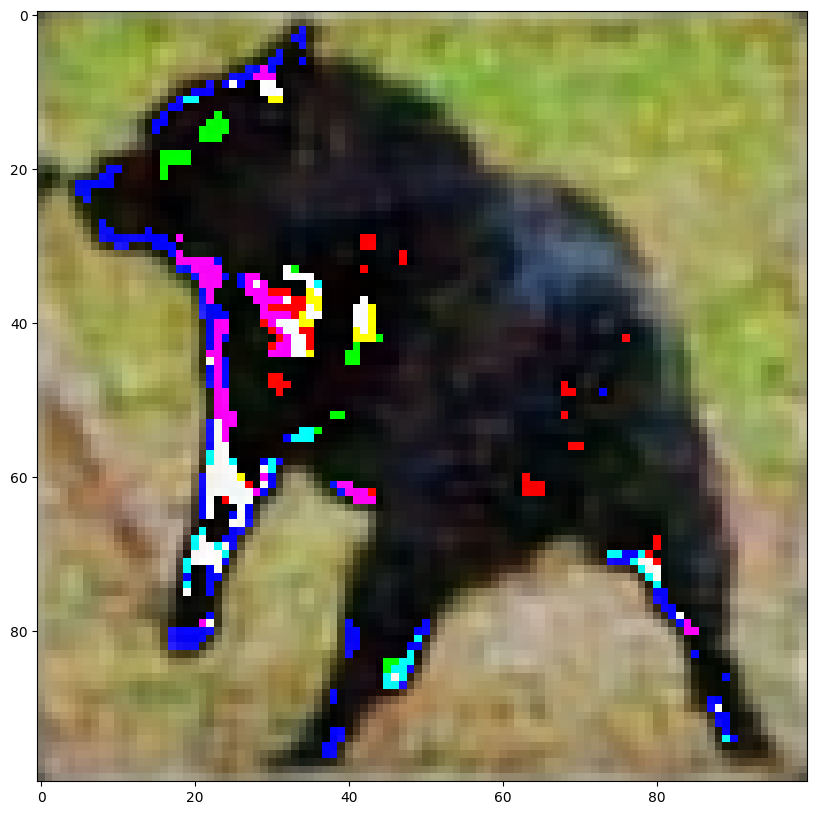

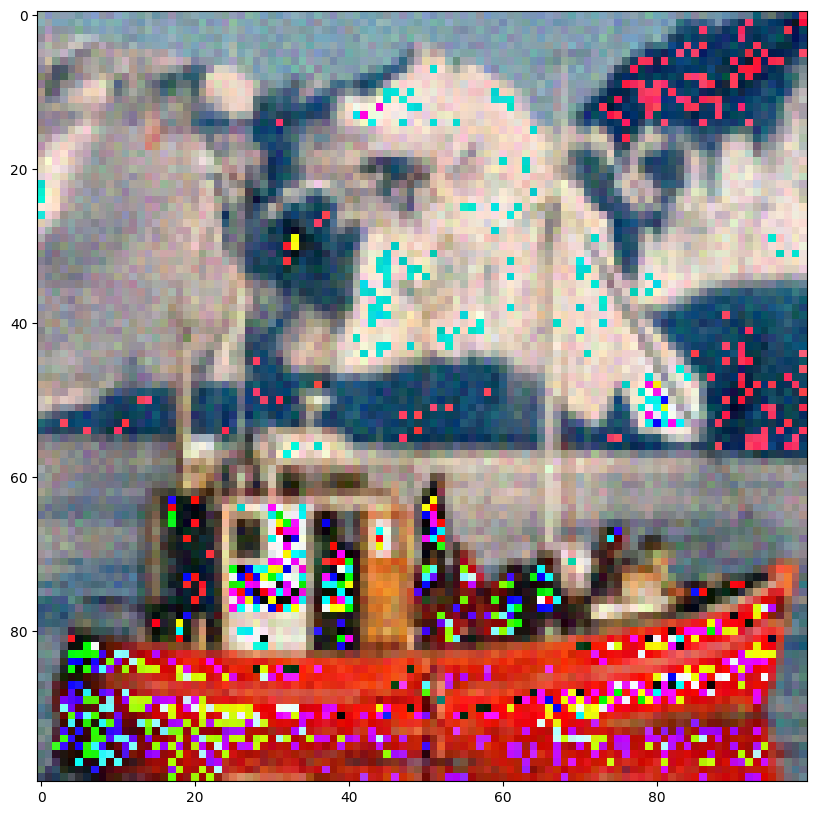

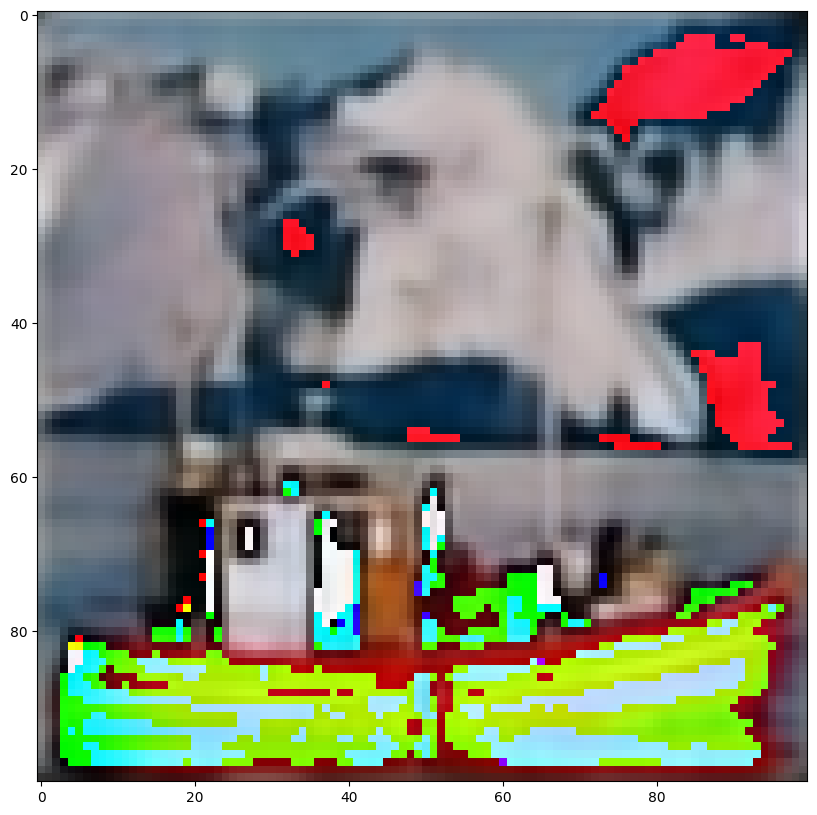

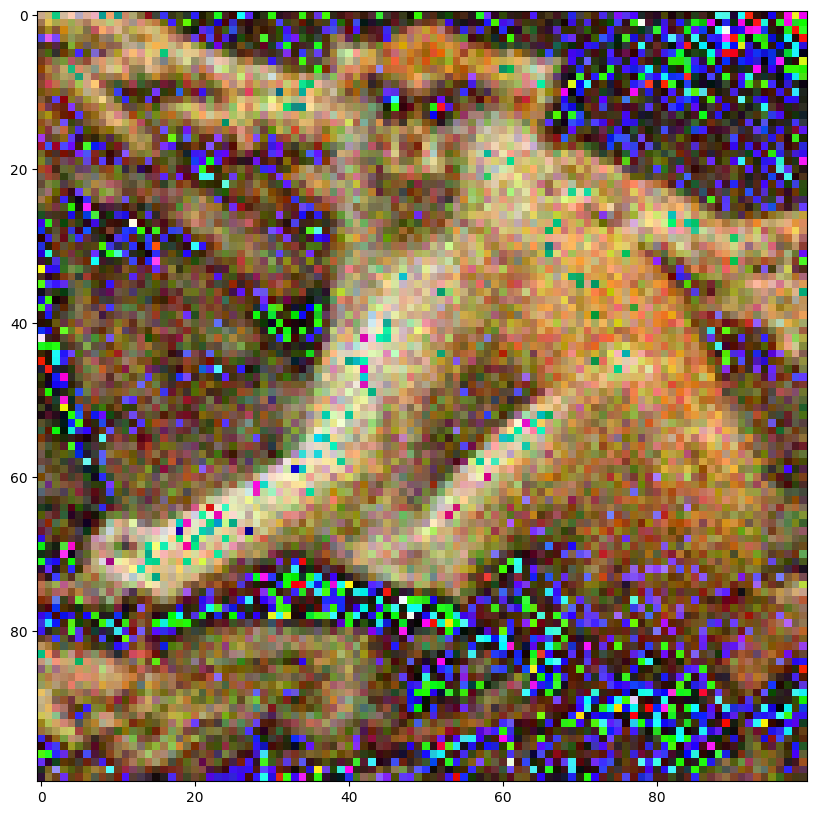

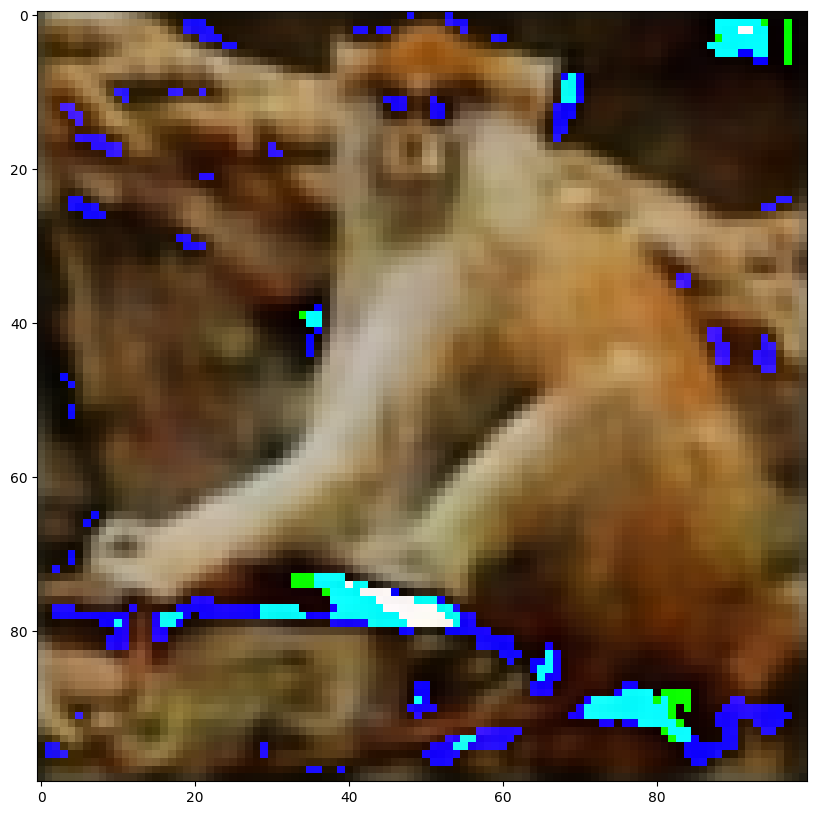

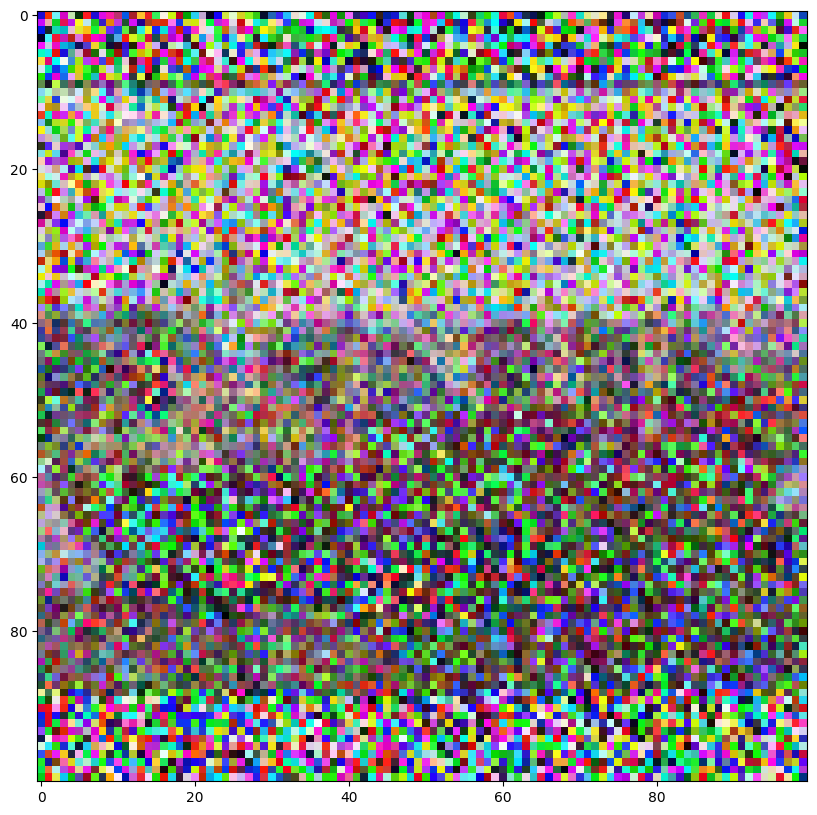

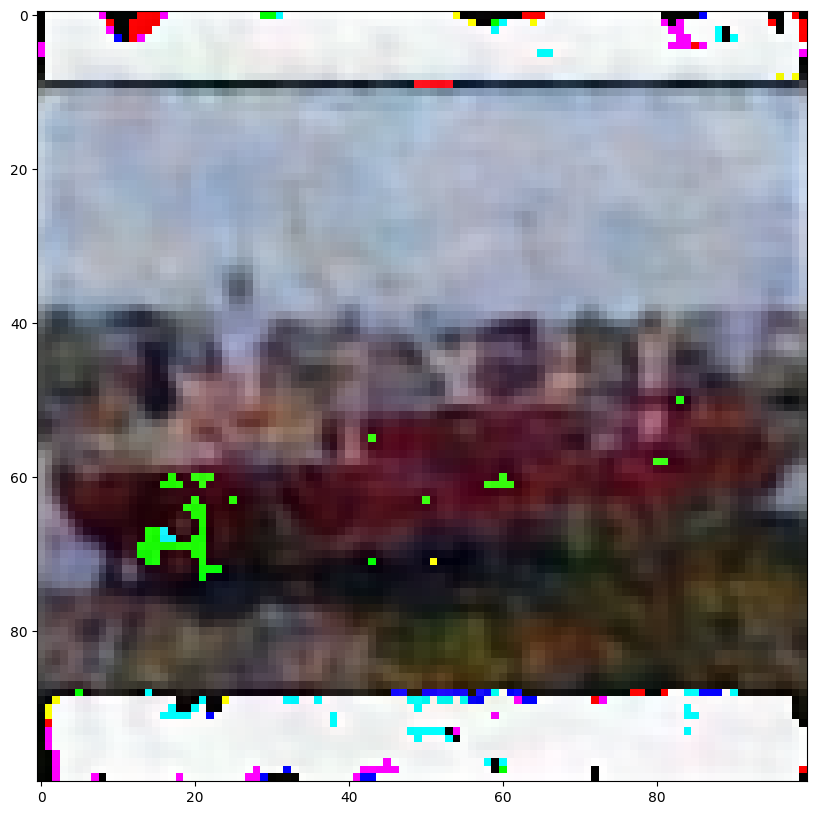

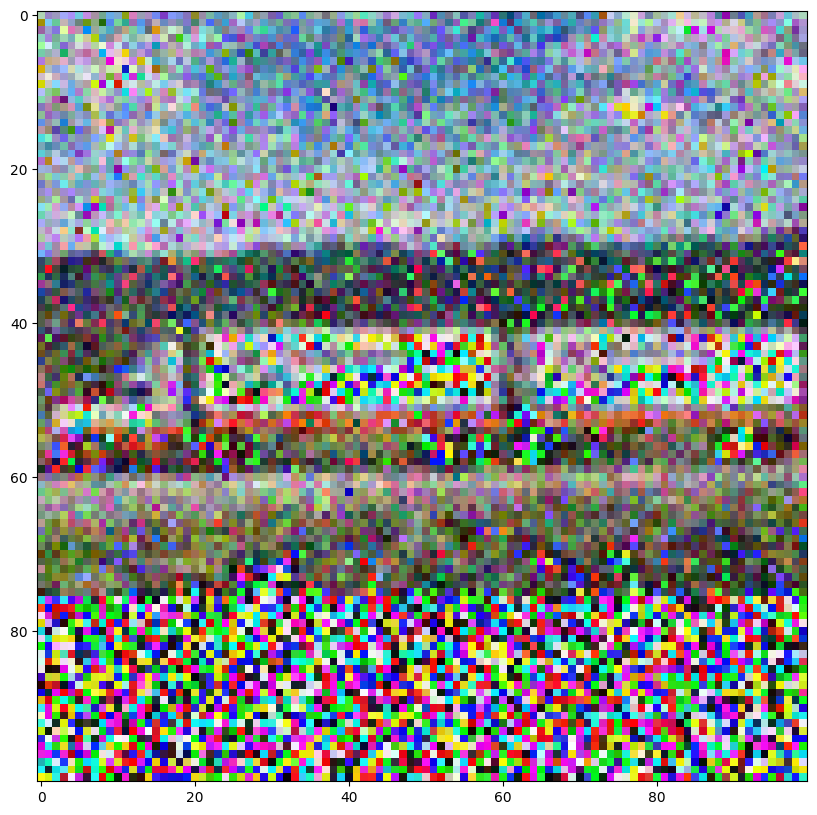

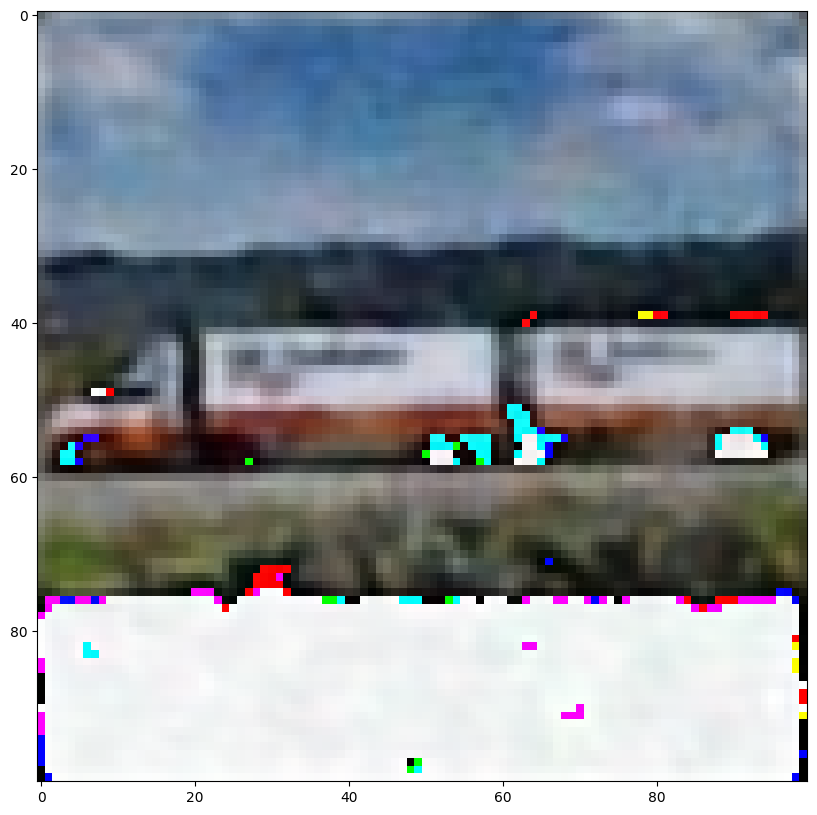

In [17]:
k = 0
with torch.no_grad():
    for data in val_dataloader:
      _, target, _, input = data
      input, target = input.to(device)/255, target.to(device)/255
      output = model(input.permute(0, 3, 1, 2))
      output = (output[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
      input = (input[0]*255).cpu().numpy().astype(np.uint8)

      plt.figure(figsize=(10, 10))
      plt.imshow(input)
      plt.show()

      plt.figure(figsize=(10, 10))
      plt.imshow(output)
      plt.show()
      k+=1
      if k == 10:
        break

**Выводы**.

С помощью четырехслойного енкодера и декодера не удалось добиться 23дБ, получилось только почти 20дБ. Возможно с увеличением глубины сети можно было бы приблизиться к 23дБ. Но сеть обучилась корректно, т.к. и на тренировочной и на валидационной выборке показала одинаковую метрику. Как видно из визуализации, сеть достаточно хорошо убирает шум даже там, где человеческому глазу не видно, что изображено на картинке.

Так же были исправлены ошибки в коде бейзлайна. Обучение проводилось на тренировочной выборке.
